In [32]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import itertools
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

In [47]:
train_path = './train'
valid_path = './valid'
test_path = './test'

In [48]:
# Data Augmentation
data_generator_with_aug = ImageDataGenerator(horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             rescale=1./255)
            
data_generator_no_aug = ImageDataGenerator(rescale=1./255)


In [49]:
# 圖檔大小IMAGEPIXELSIZE
IPS=64

In [50]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(IPS,IPS), classes=['Tiger', 'Cat','Cappuccino'], batch_size=32,shuffle=True,class_mode='categorical')
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(IPS,IPS), classes=['Tiger', 'Cat','Cappuccino'], batch_size=32,shuffle=True,class_mode='categorical')
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(IPS,IPS), classes=['Tiger', 'Cat','Cappuccino'], batch_size=32,shuffle=True,class_mode='categorical')

Found 1766 images belonging to 3 classes.
Found 601 images belonging to 3 classes.
Found 822 images belonging to 3 classes.


In [51]:
#確認 image 的shape
print(train_batches.image_shape)

(64, 64, 3)


In [52]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import regularizers

In [61]:
# create model
model = Sequential()
#Convolution
# bloack1
model.add( Conv2D(filters=16,
                  kernel_size=(6,6),
                  input_shape=(IPS,IPS,3), 
                  activation='relu',
                  padding='same' ))
model.add(Dropout(0.25))
'''model.add( Conv2D(filters=12,
                  kernel_size=(3,3),                  
                  activation='relu',
                  padding='same' ))
model.add( MaxPooling2D(pool_size=(2, 2)) )'''

# bloack2
model.add( Conv2D(filters=32,
                  kernel_size=(6, 6),
                  activation='relu',
                  padding='same') )
model.add(Dropout(0.25))
model.add( MaxPooling2D(pool_size=(2, 2)) )


In [62]:
#建立神經網路(平坦層、隱藏層、輸出層)
model.add(Flatten())
'''model.add(Dropout(0.25))'''''
'''model.add(Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.25))'''
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

In [63]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 32)        3488      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2097216   
__________

In [65]:
#取出存檔權重
try:
    model.load_weights("SaveModel/Tiger-Cat-Cappuccino-model-base-CNN.h5")
    print("載入模型成功!繼續訓練模型")
except :    
    print("載入模型失敗!開始訓練一個新模型")

載入模型失敗!開始訓練一個新模型


In [66]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=100)

In [67]:
step_size_train=train_batches.n//train_batches.batch_size
step_size_train

55

In [ ]:
# model.fit_generator
history_ft=model.fit_generator(train_batches,
                               validation_data=valid_batches,
                               steps_per_epoch=step_size_train,
                               epochs=20,
                               verbose=1,
                               class_weight='auto',
                               validation_steps=2,
                               callbacks = [early_stopping_monitor])

Epoch 1/20
55/55 [==============================] - 11s 205ms/step - loss: 10.1477 - acc: 0.3751 - val_loss: 11.9286 - val_acc: 0.2656
Epoch 2/20
55/55 [==============================] - 10s 188ms/step - loss: 10.1813 - acc: 0.3740 - val_loss: 9.1563 - val_acc: 0.4375
Epoch 3/20
55/55 [==============================] - 11s 196ms/step - loss: 10.2960 - acc: 0.3667 - val_loss: 13.1836 - val_acc: 0.1875
Epoch 4/20
55/55 [==============================] - 11s 206ms/step - loss: 10.2229 - acc: 0.3711 - val_loss: 10.2654 - val_acc: 0.3684
Epoch 5/20
55/55 [==============================] - 11s 195ms/step - loss: 10.1955 - acc: 0.3727 - val_loss: 11.9202 - val_acc: 0.2656
Epoch 6/20
55/55 [==============================] - 11s 200ms/step - loss: 10.2073 - acc: 0.3718 - val_loss: 11.1626 - val_acc: 0.3125
Epoch 7/20
55/55 [==============================] - 12s 215ms/step - loss: 10.3380 - acc: 0.3636 - val_loss: 11.6643 - val_acc: 0.2812
Epoch 8/20
55/55 [==============================] - 12s 

In [ ]:
# 训练的acc_loss图
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()

plot_training(history_ft)

In [ ]:
#儲存model權重 by h5
model.save_weights("SaveModel/Tiger-Cat-Cappuccino-model-base-CNN.h5")
print("Saved mode to disk")

In [ ]:
img_path = 'Tiger.jpg'
img = image.load_img(img_path, target_size=(IPS, IPS))

In [310]:
# 預測函數
# 輸入：model，圖片，目標尺寸
# 輸出：預測predict
target_size=(IPS, IPS)
def predict(model, img, target_size):  
    if img.size != target_size:
        img = img.resize(target_size)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x /= 255 # Rescale by 1/255
    preds = model.predict(x)
    return preds[0]

train_batches.class_indices.items()
preds = predict(model, img, target_size)
preds

array([0.23024124, 0.51537836, 0.25438038], dtype=float32)

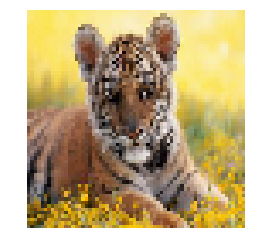

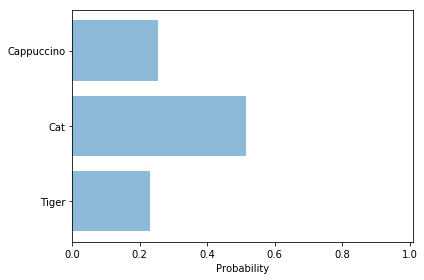

In [311]:
labels = ('Tiger', 'Cat','Cappuccino')
def plot_preds(image, preds,labels):
  """Displays image and the top-n predicted probabilities in a bar graph
  Args:
    image: PIL image
    preds: list of predicted labels and their probabilities
  """
  plt.imshow(image)
  plt.axis('off')
  plt.figure()
  plt.barh([0,1,2], preds, alpha=0.5)
  plt.yticks([0,1,2], labels)
  plt.xlabel('Probability')
  plt.xlim(0,1.01)
  plt.tight_layout()
  plt.show()
    
plot_preds(img, preds,labels)